In [1]:
from FlagEmbedding import FlagModel
import numpy as np
from sklearn.manifold import TSNE
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from pprint import pprint as pp
import time
import umap
import os
import random
import time
from contextlib import contextmanager
import torch
from sentence_transformers import SentenceTransformer

@contextmanager
def timer():
    start_time = time.time()
    try:
        yield
    finally:
        end_time = time.time()
        print(f"Elapsed time: {end_time - start_time:.4f} seconds")

In [2]:
# model = FlagModel('BAAI/bge-large-en-v1.5', 
#                   query_instruction_for_retrieval="",
#                   use_fp16=True,
#                 )
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2', model_kwargs={"torch_dtype":torch.bfloat16})

/home/tiger/.local/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [3]:
from datasets import load_dataset, load_from_disk
from datasets import load_dataset, concatenate_datasets, load_from_disk
import pandas as pd
import datasets
from datasets import Dataset
from pprint import pprint as pp
from datasets import Dataset
from sklearn.cluster import KMeans
from tqdm import tqdm
import torch
import heapq
code_data = load_dataset("sahil2801/CodeAlpaca-20k")["train"]
fin_data = load_dataset("FinGPT/fingpt-sentiment-train")["train"]
med_data = load_dataset("medalpaca/medical_meadow_medical_flashcards")["train"]
general_data = load_dataset("tatsu-lab/alpaca")["train"]
math_data = load_dataset("TIGER-Lab/MathInstruct")["train"]

def alpaca_format(example):
    if example['input'] == "":
        example["instruction"] = example["instruction"]
    else:
        example["instruction"] = example["instruction"] + " " + example['input']
    example["response"] = example['output']
    return example

def process_sft_dataset(dataset_name, dataset, dataset_sample=None)->datasets.Dataset:
    if dataset_name in ["lucasmccabe-lmi/CodeAlpaca-20k", "yahma/alpaca-cleaned", "FinGPT/fingpt-sentiment-train"]:
        dataset = dataset.map(alpaca_format, remove_columns=['input', 'output'], desc=f"Preprocessing {dataset_name} for unified format.")
    elif dataset_name in ["WizardLM/WizardLM_evol_instruct_70k"]:
        dataset = dataset.rename_column("output", "response")
    elif dataset_name in ["tatsu-lab/alpaca", "vicgalle/alpaca-gpt4", "gbharti/finance-alpaca"]:
        dataset = dataset.map(alpaca_format, remove_columns=['input', 'output', 'text'], desc=f"Preprocessing {dataset_name} for unified format.")
    elif dataset_name in ["TIGER-Lab/MathInstruct"]:
        df = pd.DataFrame(dataset)
        df = df.drop_duplicates(subset=['instruction'])
        dataset = datasets.Dataset.from_pandas(df)
        # dataset = dataset.shuffle(seed=42).select(range(51000))
        dataset = dataset.rename_column("output", "response")
        dataset = dataset.remove_columns(['source'])
    elif dataset_name in ["lighteval/MATH"]:
        dataset = dataset.rename_column("solution", "response")
        dataset = dataset.rename_column("problem", "instruction")
        dataset = dataset.remove_columns(['level', 'type'])
    elif dataset_name in ['gsm8k']:
        dataset = dataset.rename_column("question", "instruction")
        dataset = dataset.rename_column("answer", "response")
    elif dataset_name in ['medalpaca/medical_meadow_medical_flashcards']:       # TODO: 'lavita/ChatDoctor-HealthCareMagic-100k'. not sure whether to discard the instruction.
        dataset = dataset.remove_columns(['instruction'])
        dataset = dataset.rename_column("input", "instruction")
        dataset = dataset.rename_column("output", "response")
    elif "math" in dataset_name:
        dataset = dataset.remove_columns(['source'])
        dataset = dataset.rename_column("output", "response")
    else:
        raise NotImplementedError(f"Dataset {dataset_name} is not supported.")
    dataset = dataset.shuffle(seed=42)
    if dataset_sample:
        num_sample = min(len(dataset), dataset_sample)
        dataset = dataset.select(range(num_sample))
    print(f">> ===== After processing, Dataset {dataset_name} has {len(dataset)} examples. =====")
    return dataset

In [4]:
processed_data = []
# 这块一定要注意!!! name 和datasest的顺序都要改
for name, dataset in zip(["TIGER-Lab/MathInstruct","lucasmccabe-lmi/CodeAlpaca-20k","FinGPT/fingpt-sentiment-train","medalpaca/medical_meadow_medical_flashcards","tatsu-lab/alpaca",],[math_data,code_data,fin_data,med_data,general_data]):
# for name, dataset in zip(["lucasmccabe-lmi/CodeAlpaca-20k","FinGPT/fingpt-sentiment-train","medalpaca/medical_meadow_medical_flashcards", "TIGER-Lab/MathInstruct"],[code_data,fin_data,med_data,math_data]):
    tmp:datasets.Dataset = process_sft_dataset(name,dataset)
    # if "fin" in name: 
    #     tmp = tmp.shuffle(seed=42).select(range(51000))
    print(tmp.column_names)
    processed_data.append(tmp)

>> ===== After processing, Dataset TIGER-Lab/MathInstruct has 224567 examples. =====
['response', 'instruction', '__index_level_0__']
>> ===== After processing, Dataset lucasmccabe-lmi/CodeAlpaca-20k has 20022 examples. =====
['instruction', 'response']
>> ===== After processing, Dataset FinGPT/fingpt-sentiment-train has 76772 examples. =====
['instruction', 'response']
>> ===== After processing, Dataset medalpaca/medical_meadow_medical_flashcards has 33955 examples. =====
['instruction', 'response']
>> ===== After processing, Dataset tatsu-lab/alpaca has 52002 examples. =====
['instruction', 'response']


In [ ]:
# data_concated: Dataset = concatenate_datasets(processed_data)
# data_concated.save_to_disk("/mnt/bn/data-tns-live-llm/leon/datasets/fed_data/data_concated.parquet")

In [ ]:
def labeling(example, label):
    example["label"] = label
    return example

label = ["math","fin","med","code","gen",]
for i, data in enumerate(processed_data):
    data = data.map(lambda example: labeling(example, label[i]), batched=False)
    processed_data[i] = data

In [5]:
# data_concated: Dataset = concatenate_datasets(processed_data)
data_concated: Dataset = processed_data[0]

In [6]:
random.seed(42)
iid_idxs = random.sample(range(len(data_concated)), 1000)
base_data = data_concated.select(iid_idxs)
clients_data = []
for i in range(10):
    clients_data.append(base_data.shard(10,i))

data_concated = data_concated.select(list(set(range(len(data_concated)))-set(iid_idxs)))
print(len(data_concated))

223567


In [ ]:
for i in range(100):
    clients_data[i].save_to_disk(f"/mnt/bn/merlin-datavolume-tsy/leon/datasets/fed_100/base_math_{i}.parquet")

# 对0号客户端进行聚类

In [7]:
k=10
from sklearn.cluster import MiniBatchKMeans, KMeans
base_0_embeddings = model.encode(clients_data[0]["instruction"])
# 假设 embeddings 是你的嵌入数据
kmeans = KMeans(n_clusters=k, random_state=0).fit(base_0_embeddings)
labels = kmeans.labels_
# 计算每个簇的样本数量
counts = np.bincount(labels)
# 找到最大的簇的标签
largest_cluster_label = np.argmax(counts)
# 从 cluster_centers_ 中获取最大的簇的中心
cluster_center_0:np.array = kmeans.cluster_centers_[largest_cluster_label]
print(cluster_center_0.shape)

initial target device:   0%|          | 0/2 [00:00<?, ?it/s]

Chunks:   0%|          | 0/2 [00:00<?, ?it/s]You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
Chunks: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]

(1024,)


In [8]:
client_clusters = cluster_center_0.reshape((1,-1))

In [9]:
for i in range(10-1):
    i=i+1
    base_i_embeddings = model.encode(clients_data[i]["instruction"])
    # 假设 embeddings 是你的嵌入数据
    kmeans = KMeans(n_clusters=k, random_state=0).fit(base_i_embeddings)
    labels = kmeans.labels_
    similarity_scores = np.sum(kmeans.cluster_centers_ @ client_clusters.T, axis=-1)
    # print(similarity_scores.shape)
    if i < 10:
        selected_idxs = np.argsort(similarity_scores)[:10-i]
    else:
        selected_idxs = np.argsort(similarity_scores)[:5]
    # 计算每个簇的样本数量
    counts = np.bincount(labels)
    # 找到最大的簇的标签
    largest_cluster_labels = np.argsort(-counts) #降序
    largest_cluster_label = -1
    for j in largest_cluster_labels:
        if j in selected_idxs:
            largest_cluster_label = j
            break
    # 从 cluster_centers_ 中获取最大的簇的中心
    largest_cluster_center = kmeans.cluster_centers_[largest_cluster_label]
    client_clusters = np.concatenate([client_clusters,largest_cluster_center.reshape((1,-1))])
client_clusters = torch.tensor(client_clusters, dtype=torch.float32)

Chunks: 100%|██████████| 2/2 [00:00<00:00,  2.59it/s]


/home/tiger/.local/lib/python3.9/site-packages/umap/umap_.py:2437: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


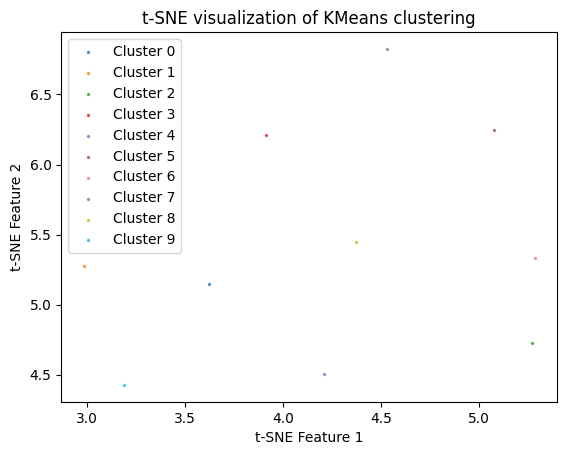

In [13]:
labels = np.array([i for i in range(10)])
# 使用 t-SNE 进行降维
umap_model = umap.UMAP(n_components=2, metric='cosine')
umap_results = umap_model.fit_transform(client_clusters)
# 可视化聚类结果
plt.figure()
for i in range(10):
    # 选择属于当前簇的点
    points = umap_results[labels == i]
    # 绘制这些点，并用不同的颜色进行区分
    plt.scatter(points[:, 0], points[:, 1], label=f'Cluster {i}', s=2, alpha=0.7)

plt.title('t-SNE visualization of KMeans clustering')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.legend()
plt.show()

# 将 data_concated 恢复为 public_data

In [10]:
data_concated: Dataset = concatenate_datasets(processed_data)
data_concated = data_concated.select(list(set(range(len(data_concated)))-set(iid_idxs)))
print(len(data_concated))

406318


In [11]:
concated_embeddings = model.encode(data_concated["instruction"])
concated_embeddings = torch.tensor(concated_embeddings, dtype=torch.float32)

Chunks: 100%|██████████| 2/2 [01:29<00:00, 44.98s/it]


In [65]:
# pool = model.start_multi_process_pool()
# concated_embeddings = torch.tensor(model.encode_multi_process(data_concated["instruction"],pool,precision='float32'))
# model.stop_multi_process_pool(pool)
# client_clusters = torch.tensor(client_clusters, dtype=torch.float32)

In [63]:
# concated_embeddings = torch.nn.functional.normalize(concated_embeddings,p=2,dim=1)
# client_clusters = torch.nn.functional.normalize(client_clusters,p=2,dim=1)

# ROUGE-L 剔除 0.7

In [11]:
import evaluate
rouge = evaluate.load('rouge')
predictions = [clients_data[0]["instruction"][0] for i in range(len(data_concated["instruction"]))]
references = data_concated["instruction"]
results = rouge.compute(predictions=predictions, references=references, use_aggregator=False, rouge_types=['rougeL'])

In [14]:
print(len(results['rougeL']))
print(results['rougeL'][:10])

406318
[0.13333333333333333, 0.1904761904761905, 0.09090909090909093, 0.18749999999999997, 0.16666666666666669, 0.28571428571428575, 0.27272727272727276, 0.16666666666666669, 0.24000000000000002, 0.24999999999999994]


In [ ]:
bins = np.arange(0, 1.05, 0.05)  # 0.05 是因为 arange 不包含上界，所以要到 1.05

rougeL_scores = results['rougeL']
# 计算直方图
hist, bin_edges = np.histogram(rougeL_scores, bins=bins)

# 打印直方图的分布统计
print("区间范围与次数：")
for i in range(len(hist)):
    print(f"{bin_edges[i]:.2f} - {bin_edges[i+1]:.2f}: {hist[i]}")

# 绘制直方图
plt.hist(rougeL_scores, bins=bins, edgecolor='black')
plt.xlabel('ROUGE-L Score')
plt.ylabel('Frequency')
plt.title('Distribution of ROUGE-L Scores')
plt.xticks(np.arange(0, 1.05, 0.05))  # 设置 x 轴刻度
plt.grid(axis='y')

# 显示图表
plt.show()

# 直接 embedding 提取

In [12]:
import numpy as np
import random
retrival_nums = [100]
print(f"k {k}")
domain = "math"
for retrival_num in retrival_nums:
    client_pos_datasets = []
    for i, sampled_data in enumerate(clients_data):
        print(i)
        similarity_scores = torch.matmul(client_clusters[i,:].cuda(), (concated_embeddings.T).cuda()).cpu()
        # filter
        filtered_scores = [(score.item(), idx) for idx, score in enumerate(similarity_scores) if score < 0.7]
        top_idxs = heapq.nlargest(retrival_num, range(len(filtered_scores)-1), key=lambda x:filtered_scores[x])
        # no filter
        # top_idxs = heapq.nlargest(5000, range(len(similarity_scores)-1), key=lambda x: similarity_scores[x])
        pos_datasets: Dataset = []
        pos_datasets = data_concated.select(top_idxs)
        pos_datasets = concatenate_datasets([pos_datasets, sampled_data])
        pos_datasets = pos_datasets.shuffle(seed=42)
        client_pos_datasets.append(pos_datasets)
        
    for i, pos_data in enumerate(client_pos_datasets):
        pos_data.save_to_disk(f"/mnt/bn/merlin-datavolume-tsy/leon/datasets/fed/iid2niid_{domain}_{retrival_num}_{i}.parquet")

k 10
0


1
2
3
4
5
6
7
8
9


Saving the dataset (1/1 shards): 100%|██████████| 200/200 [00:00<00:00, 19727.23 examples/s]


In [ ]:
domain = "med"
for i, pos_data in enumerate(client_pos_datasets):
    pos_data.save_to_disk(f"/mnt/bn/data-tns-live-llm/leon/datasets/fed_data/iid2niid_{domain}_{retrival_num}_{i}.parquet")

## 查看 score 分布

0


/tmp/ipykernel_559094/2503940916.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  similarity_scores = torch.matmul(torch.tensor(client_clusters[i,:]).cuda(), torch.tensor(concated_embeddings.T).cuda()).cpu()


Range [0.0, 0.05): 0
Range [0.05, 0.1): 0
Range [0.1, 0.15000000000000002): 0
Range [0.15000000000000002, 0.2): 0
Range [0.2, 0.25): 13
Range [0.25, 0.30000000000000004): 966
Range [0.30000000000000004, 0.35000000000000003): 18998
Range [0.35000000000000003, 0.4): 31648
Range [0.4, 0.45): 46554
Range [0.45, 0.5): 92033
Range [0.5, 0.55): 81346
Range [0.55, 0.6000000000000001): 79213
Range [0.6000000000000001, 0.65): 50357
Range [0.65, 0.7000000000000001): 5190
Range [0.7000000000000001, 0.75): 0
Range [0.75, 0.8): 0
Range [0.8, 0.8500000000000001): 0
Range [0.8500000000000001, 0.9): 0
Range [0.9, 0.9500000000000001): 0
Range [0.9500000000000001, 1.0): 0
Range [1.0, 1.05): 0
1
Range [0.0, 0.05): 0
Range [0.05, 0.1): 0
Range [0.1, 0.15000000000000002): 0
Range [0.15000000000000002, 0.2): 0
Range [0.2, 0.25): 11
Range [0.25, 0.30000000000000004): 633
Range [0.30000000000000004, 0.35000000000000003): 16394
Range [0.35000000000000003, 0.4): 34184
Range [0.4, 0.45): 52790
Range [0.45, 0.5): 

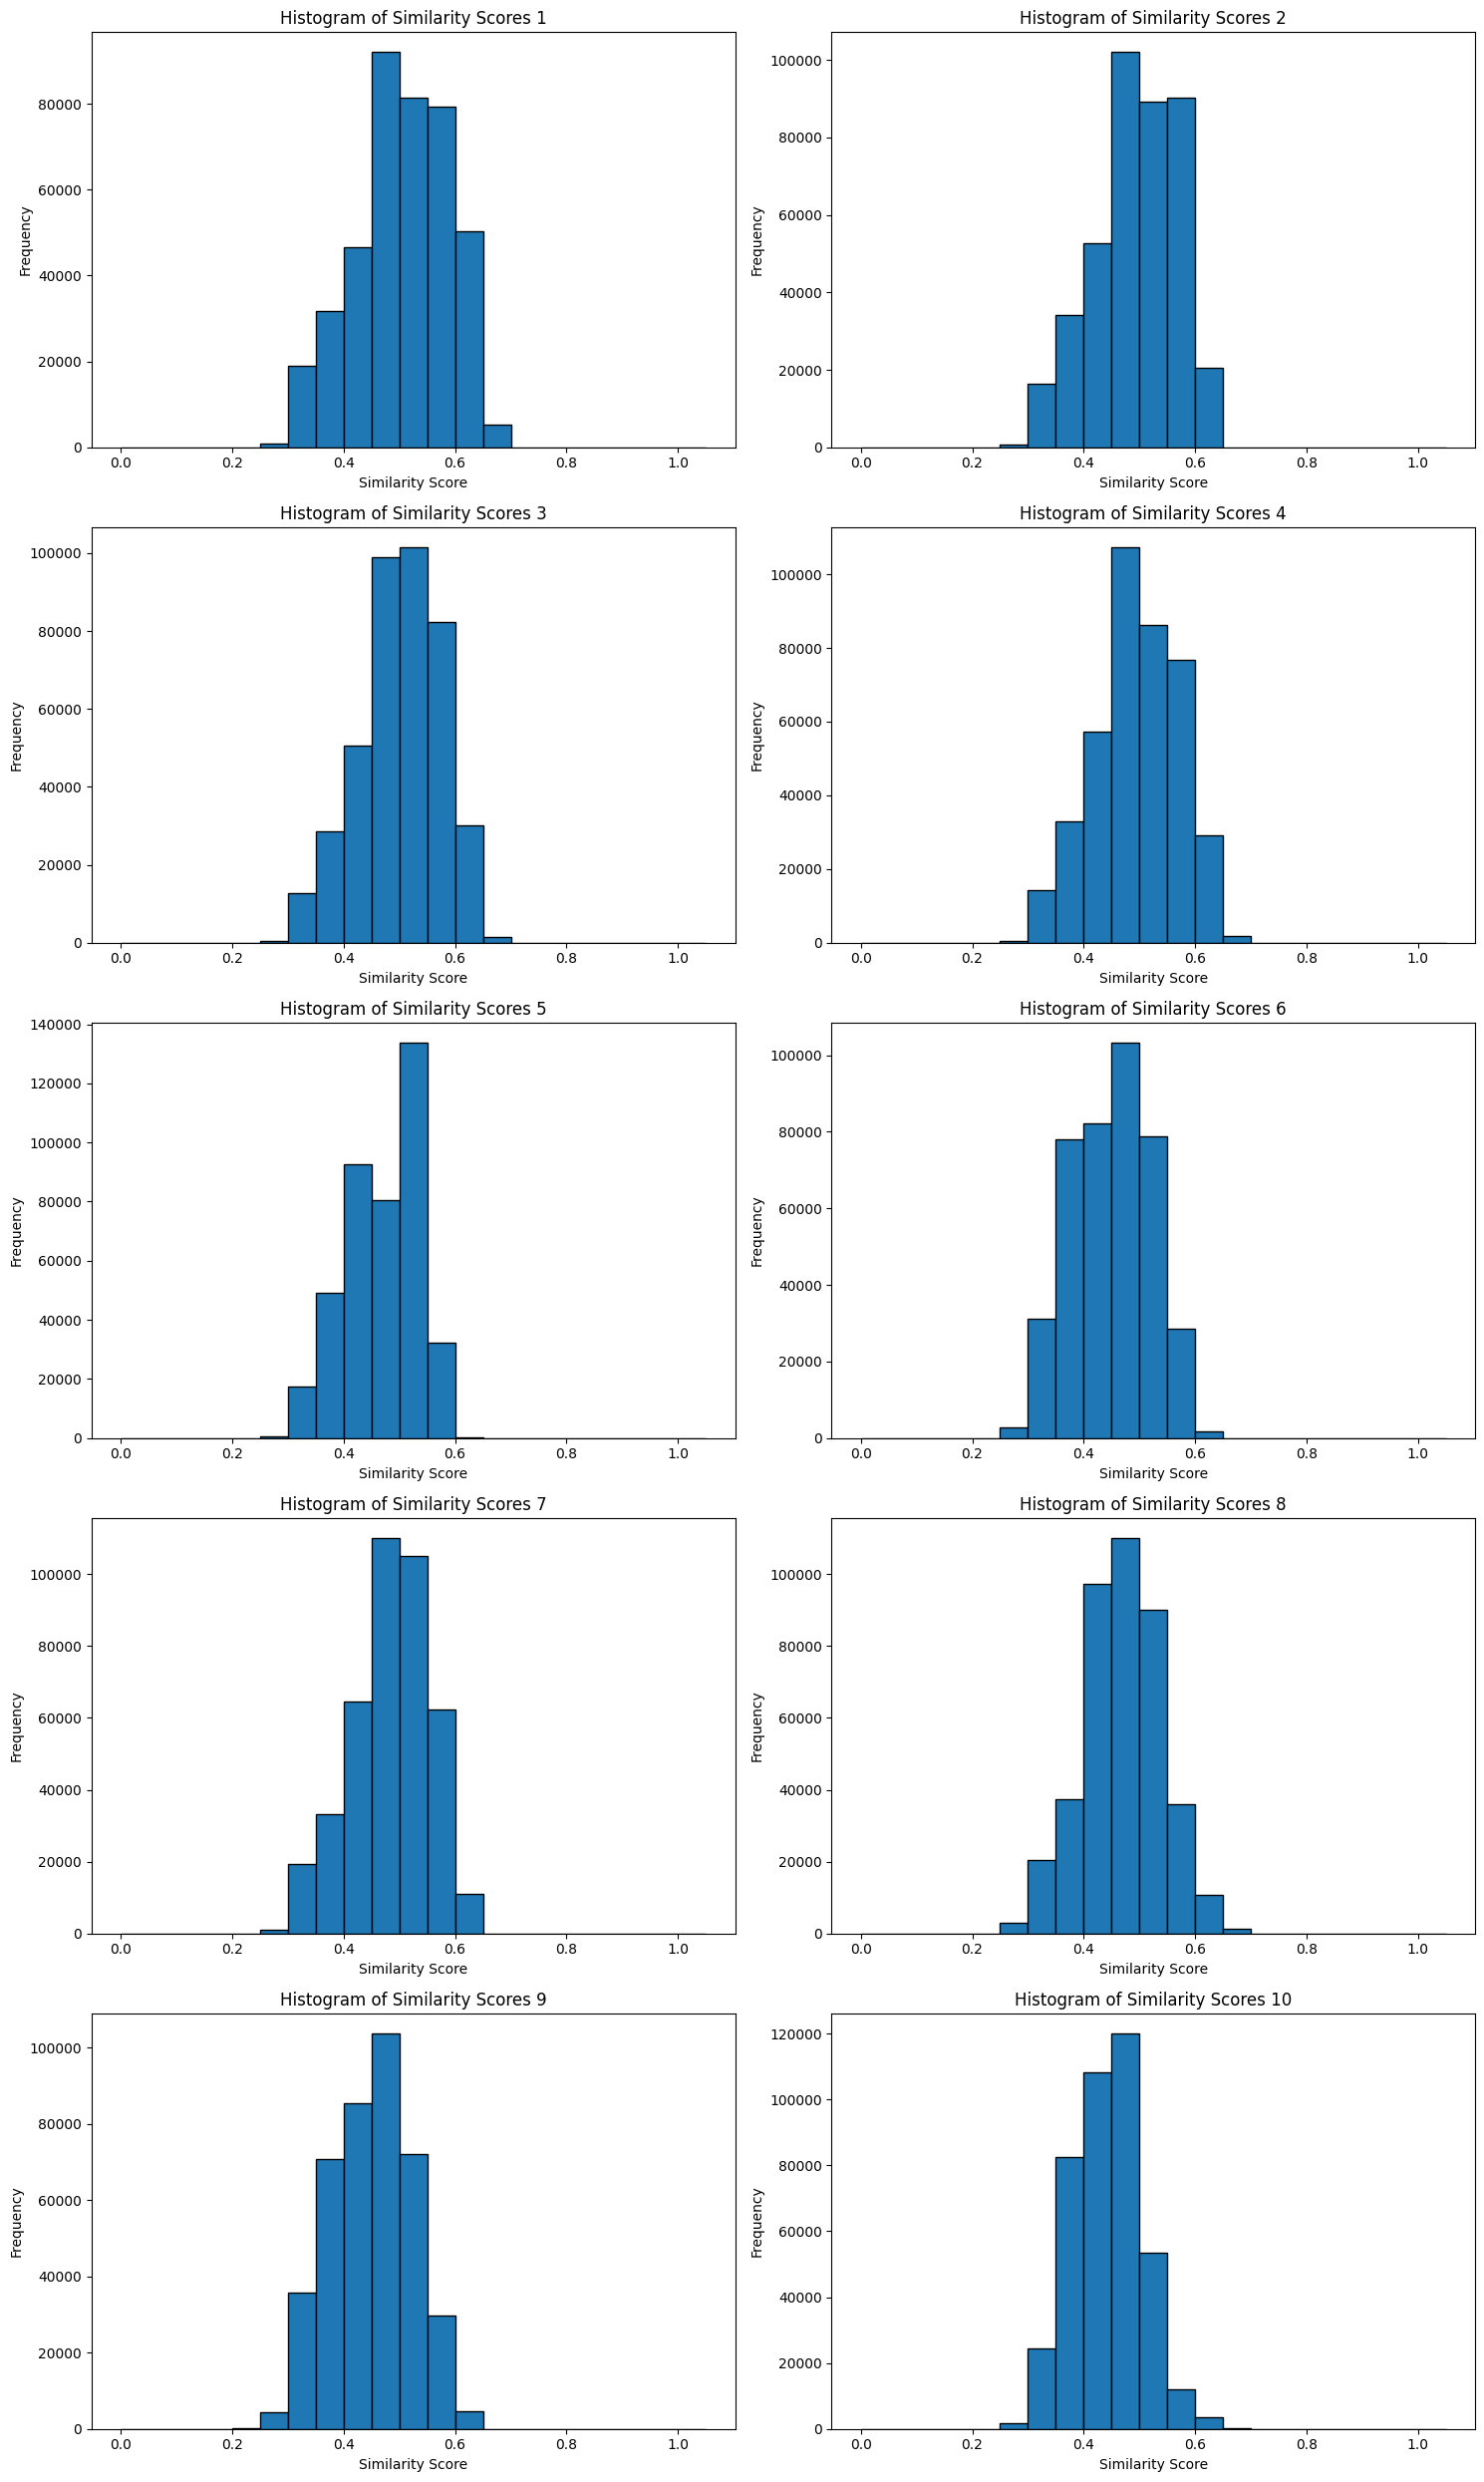

In [12]:
import numpy as np
import random
random.seed(10)

# 创建 5 行 2 列的子图布局
fig, axes = plt.subplots(5, 2, figsize=(15, 25))  # 调整 fig 大小适应子图

axes = axes.flatten()  # 将多维的子图矩阵展平成一维数组，便于迭代处理

for i, sampled_data in enumerate(clients_data):
    print(i)
    
    similarity_scores = torch.matmul(torch.tensor(client_clusters[i,:]).cuda(), torch.tensor(concated_embeddings.T).cuda()).cpu()
    import numpy as np
    import matplotlib.pyplot as plt

    # Assuming similarity_scores is a 1D tensor, convert it to a NumPy array if needed
    if hasattr(similarity_scores, 'numpy'):
        similarity_scores = similarity_scores.numpy()

    # Create a histogram with bins of size 0.1
    bins = np.arange(0, 1.1, 0.05)  # Bins from 0 to 1 with step of 0.1
    hist, bin_edges = np.histogram(similarity_scores, bins=bins)

    for j in range(len(hist)):
        print(f'Range [{bin_edges[j]}, {bin_edges[j + 1]}): {hist[j]}')

    # 在指定的子图上绘制直方图
    ax = axes[i]
    ax.hist(similarity_scores, bins=bins, edgecolor='black')
    ax.set_xlabel('Similarity Score')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Histogram of Similarity Scores {i + 1}')

# 调整子图之间的间距
plt.tight_layout()
plt.savefig('res/math_sim.eps', format='eps')
# 展示多图
plt.show()

# 不同客户端数据可视化

In [102]:
client_pos_datasets = []
for i in range(10):
    client_pos_datasets.append(load_from_disk(f"/mnt/bn/data-tns-live-llm/leon/datasets/fed_data/random_med_{i}.parquet"))

In [5]:
from datasets import load_from_disk
tmp = concatenate_datasets(client_pos_datasets)
# tmp = load_from_disk(f"/mnt/bn/data-tns-live-llm/leon/datasets/fed_data/random_med.")

In [74]:
print(len(tmp))
print(tmp[0])

51000
{'response': 'n0 = 70.0\nn1 = 61.74\nn2 = 10.0\nt0 = n2 / 100.0\nt1 = n0 * t0\nt2 = n0 - t1\nt3 = t2 - n1\nt4 = t3 / t2\nanswer = t4 * 100.0\nprint(answer)', 'instruction': "the list price of an article is rs . 70 . a customer pays rs . 61.74 for it . he was given two successive discounts , one of them being 10 % . the other discount is ? Let's write a Python program to solve it.", '__index_level_0__': 25382, 'label': 'math'}


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 假设你的数据集是一个 pandas DataFrame
# 这里我们用一个示例数据集来演示

df = pd.DataFrame(tmp)

# 统计不同 label 的频次
label_counts = df['label'].value_counts()

# 计算不同 label 的占比
label_percentages = label_counts / label_counts.sum() * 100

# 打印统计结果
print("label 频次：")
print(label_counts)
print("\nlabel 占比：")
print(label_percentages)

# 绘制饼状图
plt.figure(figsize=(8, 8))
plt.pie(
    label_counts, 
    labels=label_counts.index, 
    autopct='%1.1f%%', 
    startangle=140
)
plt.title('Label Distribution')

# 显示图表
plt.show()

In [ ]:
# 遍历数据并进行 t-SNE 可视化
embeddings = []
labels = []
for i, data in enumerate(client_pos_datasets):
    embedding = model.encode(data["instruction"])
    embeddings.extend(embedding)
    labels.extend([i]*len(embedding))

embeddings = np.array(embeddings)
labels = np.array(labels)
umap_model = umap.UMAP(n_components=2, metric='cosine')
umap_results = umap_model.fit_transform(embeddings)
# 调整子图间距
plt.tight_layout()
# 展示所有子图
plt.show()

plt.figure(figsize=(12, 12))
for i in range(10):
    # 选择属于当前簇的点
    points = umap_results[labels == i]
    # 绘制这些点，并用不同的颜色进行区分
    plt.scatter(points[:, 0], points[:, 1], label=f'Cluster {i}', s=2, alpha=0.7)

plt.title('t-SNE visualization of KMeans clustering')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.legend()
plt.show()

# 可视化不同采样方法的覆盖率

In [5]:
method_datasets = [processed_data[0].shuffle().select(range(10000))]
for name in ["pos_math","iid2niid_math_filter","random_math"]:
    client_pos_datasets = []
    for i in range(10):
        client_pos_datasets.append(load_from_disk(f"/mnt/bn/data-tns-live-llm/leon/datasets/fed_data/{name}_{i}.parquet"))
    method_datasets.append(concatenate_datasets(client_pos_datasets).shuffle().select(range(5000)))

In [7]:
import umap
embeddings = []
labels = []
for i, data in enumerate(method_datasets):
    embedding = model.encode(data["instruction"])
    embeddings.extend(embedding)
    labels.extend([i]*len(embedding))

/home/tiger/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


<Figure size 640x480 with 0 Axes>

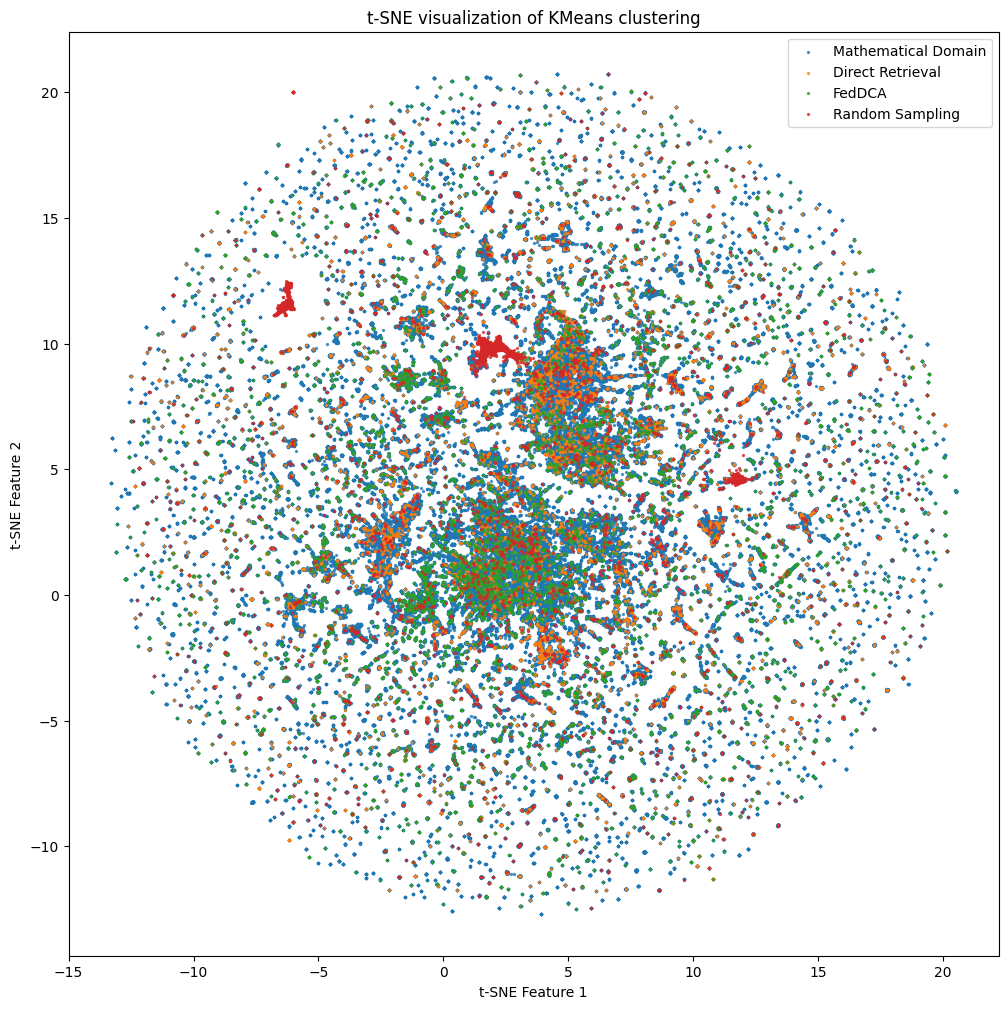

In [ ]:
embeddings = np.array(embeddings)
labels = np.array(labels)
umap_model = umap.UMAP(n_components=2, metric='cosine')
umap_results = umap_model.fit_transform(embeddings)
# 调整子图间距
plt.tight_layout()
# 展示所有子图
plt.show()

plt.figure(figsize=(12, 12))
for i, name in zip(range(len(method_datasets)), ["Mathematical Domain","Direct Retrieval","FedDCA","Random Sampling"]):
    # 选择属于当前簇的点
    points = umap_results[labels == i]
    # 绘制这些点，并用不同的颜色进行区分
    plt.scatter(points[:, 0], points[:, 1], label=f'{name}', s=2, alpha=0.7)

plt.title('t-SNE visualization of KMeans clustering')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.legend()
plt.show()

/home/tiger/.local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


<Figure size 640x480 with 0 Axes>

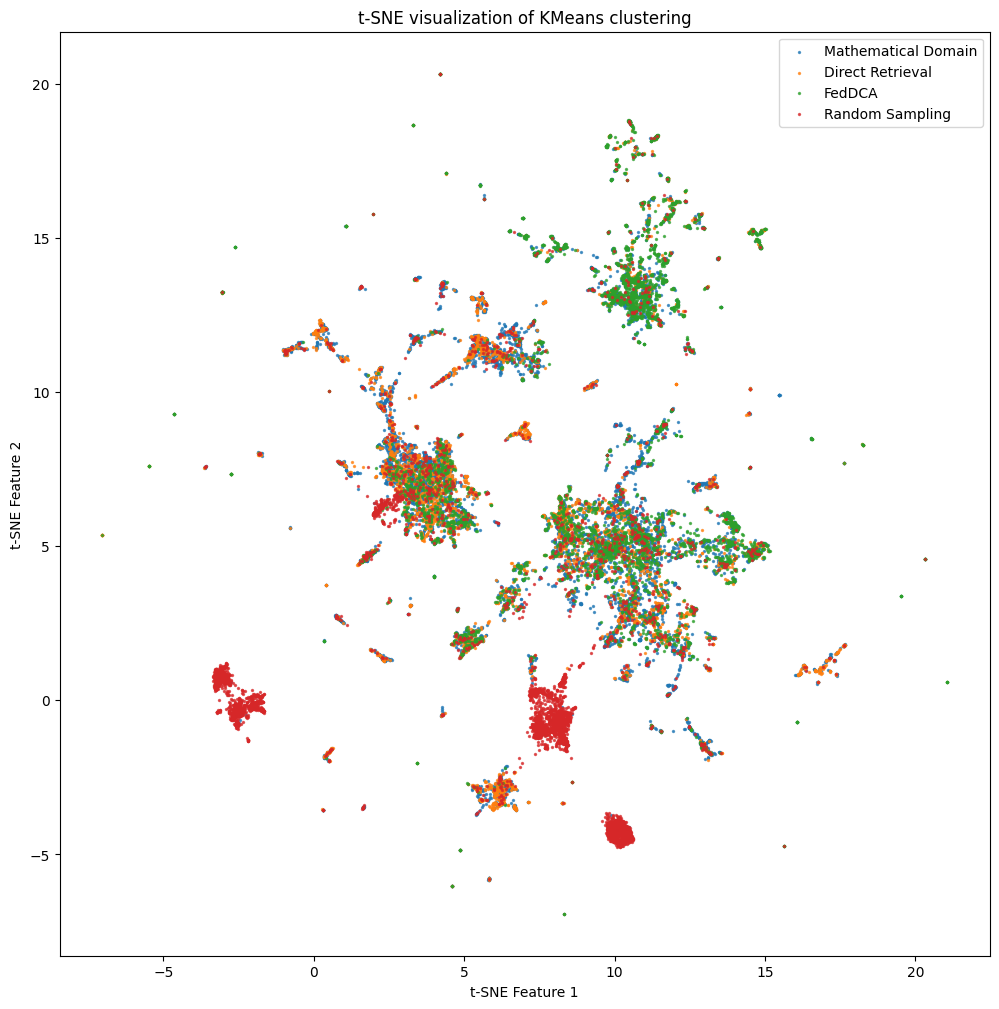

In [8]:
embeddings = np.array(embeddings)
labels = np.array(labels)
umap_model = umap.UMAP(n_components=2, metric='cosine')
umap_results = umap_model.fit_transform(embeddings)
# 调整子图间距
plt.tight_layout()
# 展示所有子图
plt.show()

plt.figure(figsize=(12, 12))
for i, name in zip(range(len(method_datasets)), ["Mathematical Domain","Direct Retrieval","FedDCA","Random Sampling"]):
    # 选择属于当前簇的点
    points = umap_results[labels == i]
    # 绘制这些点，并用不同的颜色进行区分
    plt.scatter(points[:, 0], points[:, 1], label=f'{name}', s=2, alpha=0.7)

plt.title('t-SNE visualization of KMeans clustering')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.legend()
plt.show()

# 使用tsne 绘制

In [ ]:
method_datasets = [processed_data[0].shuffle().select(range(10000))]
for name in ["pos_math","iid2niid_math_filter","random_math"]:
    client_pos_datasets = []
    for i in range(10):
        client_pos_datasets.append(load_from_disk(f"/mnt/bn/data-tns-live-llm/leon/datasets/fed_data/{name}_{i}.parquet"))
    method_datasets.append(concatenate_datasets(client_pos_datasets).shuffle().select(range(5000)))
import umap
embeddings = []
labels = []
for i, data in enumerate(method_datasets):
    embedding = model.encode(data["instruction"])
    embeddings.extend(embedding)
    labels.extend([i]*len(embedding))

<Figure size 640x480 with 0 Axes>

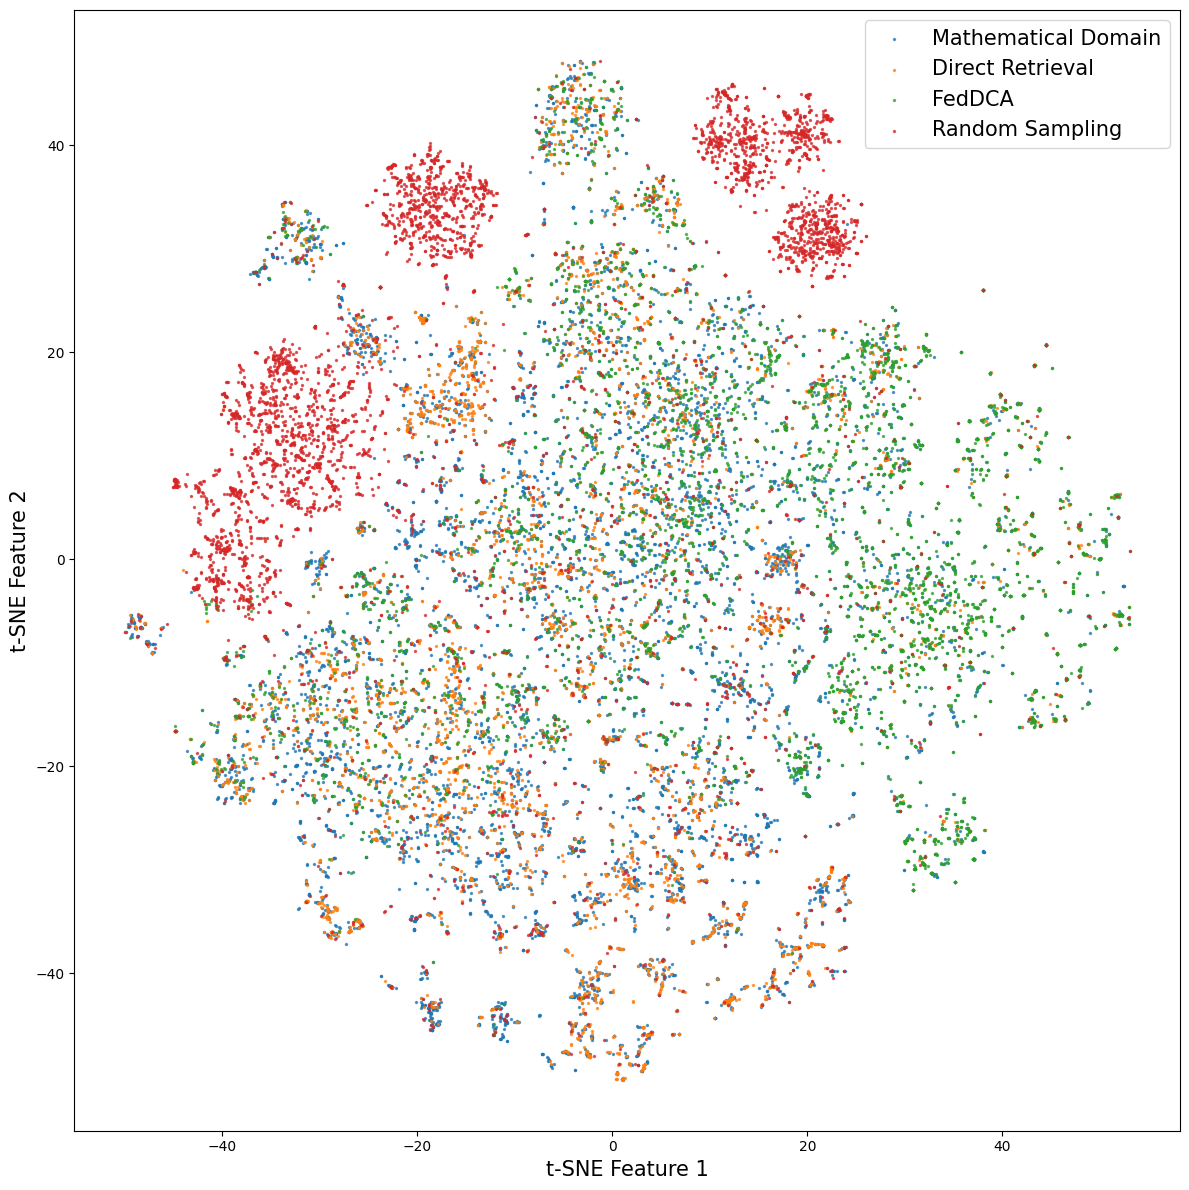

In [9]:
import numpy as np
# from sklearn.manifold import TSNE
from MulticoreTSNE import MulticoreTSNE as TSNE
import matplotlib.pyplot as plt

# 假设 embeddings 和 labels 已经定义好
embeddings = np.array(embeddings)
labels = np.array(labels)

# 使用 TSNE 替代 UMAP
# tsne_model = TSNE(n_components=2, metric='cosine')
# tsne_model = TSNE(n_components=2, metric='cosine', n_jobs=128)
tsne_model = TSNE(n_components=2, n_jobs=128)
tsne_results = tsne_model.fit_transform(embeddings)

# 调整子图间距
plt.tight_layout()
# 展示所有子图
# plt.show()

plt.figure(figsize=(12, 12))
for i, name in zip(range(len(method_datasets)), ["Mathematical Domain", "Direct Retrieval", "FedDCA", "Random Sampling"]):
    # 选择属于当前簇的点
    points = tsne_results[labels == i]
    # 绘制这些点，并用不同的颜色进行区分
    plt.scatter(points[:, 0], points[:, 1], label=f'{name}', s=2, alpha=0.7)

# plt.title('t-SNE visualization of KMeans clustering')
plt.xlabel('t-SNE Feature 1', fontsize=20)
plt.ylabel('t-SNE Feature 2', fontsize=20)
plt.legend(fontsize=20, markerscale=5)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
plt.savefig("domain_coverage.png",dpi=600,format="png")
plt.show()

In [12]:
client_pos_datasets = []
for i in range(10):
    client_pos_datasets.append(load_from_disk(f"/mnt/bn/data-tns-live-llm/leon/datasets/fed_data/iid2niid_math_5000_projector_{i}.parquet"))

In [13]:
client_pos_datasets[0]["instruction"][:10]

['A cylinder has a radius of 5 cm and a height of 10 cm. What is the total surface area of the cylinder, rounded to the nearest square centimeter?',
 '15 men take 21 days of 8 hours each to do a piece of work. How many days of 6 hours each would 21 women take to do the same. If 3 women do as much work as 2 men?\nAnswer Choices: (A) 32 (B) 87 (C) 30 (D) 99 (E) 77',
 "There were 13.0 soccer games this year, but Alyssa missed to go to 11.0 of them. She plans to go to 15.0 games next year . How many soccer games will Alyssa go to. Let's program in Python in the response.",
 "Baseball season opened up with the Chicago Cubs at home at Wrigley Field. They scored 2 home runs in the third inning, 1 home run in the fifth inning and 2 more home runs in the eighth inning. Their opponents, the Cardinals, scored 1 home run in the second inning and 1 home run in the fifth inning. How many more home runs did the Chicago Cubs score than the Cardinals in the game? Let's write a program.",
 'Consider a s